In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
import fitsio
from tqdm import tqdm

from astroquery.jplhorizons import Horizons
from sbident import SBIdent

from tess_ephem import ephem, TessEphem, log
from tess_asteroid_ml import *
from tess_asteroid_ml.utils import *
from tess_asteroid_ml.make_TESS_asteroid_db import *
from ipywidgets import *

In [83]:
sector = 8
camera = 1
ccd = 1
maglim = 22
scc_str = f"s{sector:04}-{camera}-{ccd}"
scc_str

's0008-1-1'

In [84]:
ffi_file = get_FFI_name(sector=sector, camera=camera, ccd=0, correct=False)
ffi_file

['https://archive.stsci.edu/missions/tess/ffi/s0008/2019/043/1-1/tess2019043222935-s0008-1-1-0136-s_ffic.fits',
 'https://archive.stsci.edu/missions/tess/ffi/s0008/2019/043/1-2/tess2019043222935-s0008-1-2-0136-s_ffic.fits',
 'https://archive.stsci.edu/missions/tess/ffi/s0008/2019/043/1-3/tess2019043222935-s0008-1-3-0136-s_ffic.fits',
 'https://archive.stsci.edu/missions/tess/ffi/s0008/2019/043/1-4/tess2019043222935-s0008-1-4-0136-s_ffic.fits']

In [85]:
with fits.open(ffi_file[0]) as ffi:
    wcs = WCS(ffi[1])
    date_obs = Time([ffi[0].header["DATE-OBS"], ffi[0].header["DATE-END"]])

Set MJD-END to 58526.963256 from DATE-END'. [astropy.wcs.wcs]


In [86]:
COL, ROW, F, RA, DEC = {}, {}, {}, {}, {}

for k, ccd in enumerate(range(1,5)):
    col_2d, row_2d, f2d = load_ffi_image(
                    "TESS",
                    ffi_file[k],
                    1,
                    None,
                    [0, 0],
                    return_coords=True,
                )
    ra_2d, dec_2d = wcs.all_pix2world(np.vstack([col_2d.ravel(), row_2d.ravel()]).T, 0.0).T
    ra_2d = ra_2d.reshape(col_2d.shape)
    dec_2d = dec_2d.reshape(col_2d.shape)

    COL[ccd] = col_2d
    ROW[ccd] = row_2d
    F[ccd] = f2d
    RA[ccd] = ra_2d
    DEC[ccd] = dec_2d

In [87]:
jpl_sb_bright_new = []
for cam in range(1, 5):
    # if cam != camera:
    #     continue
    scc_str = f"s{sector:04}-{cam}-{0}"

    jpl_sbi_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/jpl_small_bodies_tess_{scc_str}_catalog.csv"

    if os.path.isfile(jpl_sbi_file):
        print("Loading from CSV file...")
        jpl_sb = pd.read_csv(jpl_sbi_file, index_col=0)
        print(f"cam {cam} shape", jpl_sb.shape)

    jpl_sb = jpl_sb.query(f"V_mag <= {maglim}")
    jpl_sb_bright_new.append(jpl_sb)
    
jpl_sb_bright_new = pd.concat(jpl_sb_bright_new, axis=0).drop_duplicates(subset=["Object name"]).reset_index()
jpl_sb_bright.tail()

Loading from CSV file...
cam 1 shape (34223, 22)
Loading from CSV file...
cam 2 shape (2399, 22)
Loading from CSV file...
cam 3 shape (281, 22)
Loading from CSV file...
cam 4 shape (196, 22)


/var/folders/lz/gmp0cdwx3_v5v7qww7r6sg100000gn/T/ipykernel_80377/23639038.py:11: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  jpl_sb = pd.read_csv(jpl_sbi_file, index_col=0)


,index,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",...,Absolute magntiude (H),Magnitude slope (G),Eccentricity,Perihelion (au),Time of perihelion passage (JD),Longitude of ascending node (deg),Argument of perihelion (deg),Inclination (deg),Epoch (JD),H_mag
19554,48,(2013 CW32),10:18:21.94,-61:21:58.0,100000.0,20000.0,110000.0,18.2,-614.30,1068.0,...,22.08,0.15,0.378360,0.562303,2.460322e+06,132.08513,228.856140,26.063571,2460400.5,22.08
19555,49,(2019 CA2),07:41:04.31,-59:37:45.9,40000.0,20000.0,54000.0,20.1,2568.00,3562.0,...,27.20,0.15,0.450675,0.890795,2.458474e+06,131.58141,307.246060,6.821725,2458520.5,27.20
19556,50,(2019 HC),11:25:13.57,-52:29:08.1,100000.0,50000.0,150000.0,19.9,38.62,-55.4,...,17.21,0.15,0.550729,1.199674,2.460195e+06,215.54855,6.350925,35.320273,2460400.5,17.21
19557,52,(2002 CY9),11:36:34.83,-51:43:44.0,100000.0,50000.0,160000.0,20.6,-110.50,-100.1,...,19.20,0.15,0.507421,0.811248,2.460748e+06,305.28942,117.363880,41.960626,2460400.5,19.20
19558,54,(2019 BY3),10:47:39.82,-58:54:19.3,100000.0,30000.0,120000.0,21.4,746.90,-862.9,...,27.40,0.15,0.446142,0.973401,2.458531e+06,306.98779,204.412400,9.179279,2458512.5,27.40


In [88]:
sb_ephems_lowres = {}

for k, row in tqdm(jpl_sb_bright_new.iterrows(), total=len(jpl_sb_bright_new)):
    
    feath_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/tracks/sector{sector:04}/tess-ffi_s{sector:04}-0-0_{row['id'].replace(' ', '-')}_hires.feather"
    if os.path.isfile(feath_file):
        ephems_aux = pd.read_feather(feath_file)
        step = len(ephems_aux) // 27 - 1 if len(ephems_aux) > 100 else 4
        sb_ephems_lowres[k] = ephems_aux

100%|██████████████████████████████████████████████████████████████████████████| 22914/22914 [01:13<00:00, 311.61it/s]


In [89]:
len(sb_ephems_lowres)

12784

In [91]:
jpl_sb_bright_new.query("kind == 'c'")

,index,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",ra,dec,V_mag,...,Magnitude slope (G),Eccentricity,Perihelion (au),Time of perihelion passage (JD),Longitude of ascending node (deg),Argument of perihelion (deg),Inclination (deg),Epoch (JD),H_mag,kind
17199,26962,C/2006 S3 (LONEOS),09:38:58.24,-00:53:36.5,20.5N,-10.020,2.8280,144.742667,-0.893472,20.5,...,NaN,1.003516,5.131152,2.456034e+06,38.370869,140.130170,166.032680,2456039.5,NaN,c
17200,26966,P/2019 B2 (Groeller),09:20:21.23,-01:56:12.0,20.1N,-15.940,16.0000,140.088458,-1.936667,20.1,...,NaN,0.372902,2.416517,2.458643e+06,176.459300,358.709920,16.829150,2458543.5,NaN,c
22861,203,C/2017 W2 (Leonard),07:08:29.46,-38:41:44.9,21.1N,-34.780,0.2378,107.122750,-38.695806,21.1,...,NaN,0.711257,3.957327,2.458059e+06,312.809060,169.157710,98.179291,2458113.5,NaN,c
22880,280,C/2019 E3 (ATLAS),10:16:25.58,-37:05:55.7,19.1N,-12.380,0.1830,154.106583,-37.098806,19.1,...,NaN,1.002303,10.313916,2.460262e+06,347.253520,280.643220,84.297401,2459563.5,NaN,c
22899,136,C/2013 P3 (Palomar),01:34:35.25,-57:20:46.7,20.5N,5.106,6.7500,23.646875,-57.346306,20.5,...,NaN,1.001156,8.646522,2.456985e+06,177.275810,177.190710,93.906204,2456907.5,NaN,c
22900,139,C/2020 H6 (ATLAS),10:19:21.74,-65:17:34.4,19.8N,-8.291,-2.6490,154.840583,-65.292889,19.8,...,NaN,1.000570,4.702870,2.459489e+06,213.708300,20.344599,79.970782,2459586.5,NaN,c
22901,140,C/2020 O2 (Amaral),11:21:55.98,-73:19:03.7,19.5N,-5.065,-9.8300,170.483250,-73.317694,19.5,...,NaN,1.002325,4.862254,2.459455e+06,256.757250,10.309432,71.750811,2459637.5,NaN,c


In [90]:
for k in jpl_sb_bright_new.query("kind == 'c'").index.values:
    try:
        print(k, sb_ephems_lowres[k].query("camera == 1").shape, set(sb_ephems_lowres[k].query("camera == 1").ccd))
    except:
        continue

17199 (742, 13) {3, 4}
17200 (968, 13) {4}
22880 (0, 13) set()
22900 (0, 13) set()


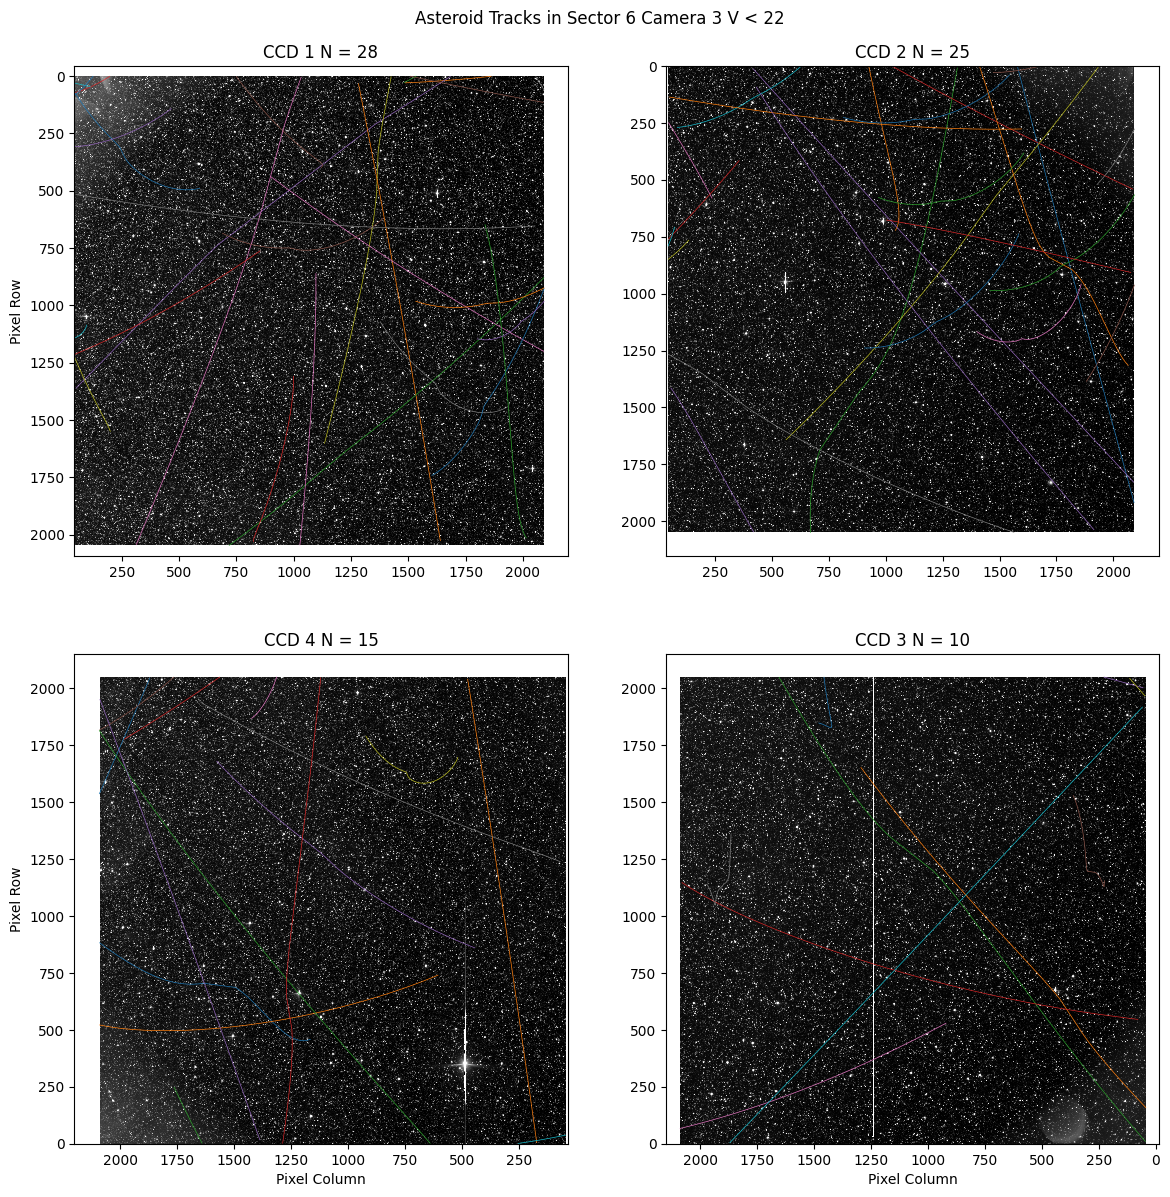

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(14,14))
plt.suptitle(f"Asteroid Tracks in Sector {sector} Camera {camera} V < {maglim}", y=0.92)

for k, ccd in enumerate(range(1,5)):
    if camera in [1, 2]:
        if ccd == 1:
            ax_ = ax[1, 1]
            ax_.invert_xaxis()
        elif ccd == 2:
            ax_ = ax[1, 0]
            ax_.invert_xaxis()
        elif ccd == 3:
            ax_ = ax[0, 0]
            ax_.invert_yaxis()
        elif ccd == 4:
            ax_ = ax[0, 1]
            ax_.invert_yaxis()

    if camera in [3, 4]:
        if ccd == 1:
            ax_ = ax[0, 0]
            ax_.invert_yaxis()
        elif ccd == 2:
            ax_ = ax[0, 1]
            ax_.invert_yaxis()
        elif ccd == 3:
            ax_ = ax[1, 1]
            ax_.invert_xaxis()
        elif ccd == 4:
            ax_ = ax[1, 0]
            ax_.invert_xaxis()

    vlo, lo, mid, hi, vhi = np.nanpercentile(F[ccd], [0.2, 1, 50, 95, 99.8])
    cnorm = colors.LogNorm(vmin=lo, vmax=vhi)
    ax_.pcolormesh(COL[ccd], ROW[ccd], F[ccd], norm=cnorm, cmap="Greys_r", rasterized=True)
    
    counter = 0
    for i, (k, val) in enumerate(sb_ephems_lowres.items()):
        if len(val) == 0:
            continue
        val = val.query(f"camera == {camera} and ccd == {ccd}")
        if len(val) > 0: 
            counter += 1
            ax_.plot(val.column, val.row, "-", lw=.5, rasterized=True)
        # if i == 10: break
    
    ax_.set_title(f"CCD {ccd} N = {counter}")

    ax_.axis('equal')

ax[1,0].set_xlabel("Pixel Column")
ax[1,1].set_xlabel("Pixel Column")
ax[0,0].set_ylabel("Pixel Row")
ax[1,0].set_ylabel("Pixel Row")
plt.show()

In [76]:
track_lengh = []
track_time = []
vmag = []
rate = []
speed = []
incl = []

for cam in tqdm(range(1, 5), total=4, leave=False):
    track_lengh_cam = []
    track_time_cam = []
    vmag_cam = []
    rate_cam = []
    speed_cam, incl_cam = [], []
    for k, val in sb_ephems_lowres.items():
        for chip in range(1, 5):
            # if chip != 3: continue
            aux = val.query(f"camera == {cam} and ccd == {chip}")
            if len(aux) == 0:
                continue
            hypot = np.hypot(aux.column.values[-1] - aux.column.values[0], 
                             aux.row.values[-1] - aux.row.values[0])
            track_lengh_cam.append(hypot)
            track_time_cam.append(aux.time.values[-1] - aux.time.values[0])
            vmag_cam.append(aux.vmag.mean())
            rate_cam.append(aux.pixels_per_hour.mean())
            incl_cam.append(jpl_sb_bright.iloc[k]["Inclination (deg)"])
            hypot = np.hypot(jpl_sb_bright.iloc[k]['RA rate ("/h)'], 
                             jpl_sb_bright.iloc[k]['Dec rate ("/h)'])
            speed_cam.append(hypot)
    track_lengh.append(np.array(track_lengh_cam))
    track_time.append(np.array(track_time_cam))
    vmag.append(np.array(vmag_cam))
    rate.append(np.array(rate_cam))
    incl.append(np.array(incl_cam))
    speed.append(np.array(speed_cam))

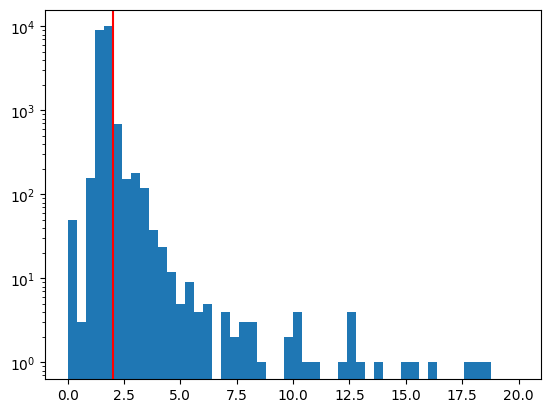

In [77]:
plt.hist(rate[0], bins=50, log=True, range=(0, 20))
plt.axvline(2, c="r")
plt.show()

In [78]:
speed[0]

array([  30.17804666,   31.79117242,   42.48133943, ...,  666.19660281,
       1065.78889561, 1065.78889561])

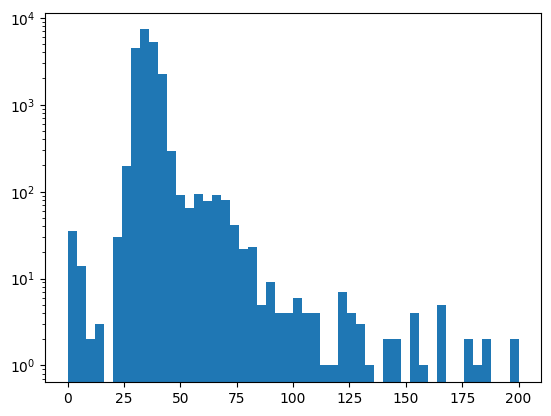

In [80]:
plt.hist(speed[0], bins=50, log=True, range=[0, 200])
# plt.axvline(2, c="r")
plt.show()

/var/folders/lz/gmp0cdwx3_v5v7qww7r6sg100000gn/T/ipykernel_11009/3777625262.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.ravel()[k].set_xlim(0, 100)


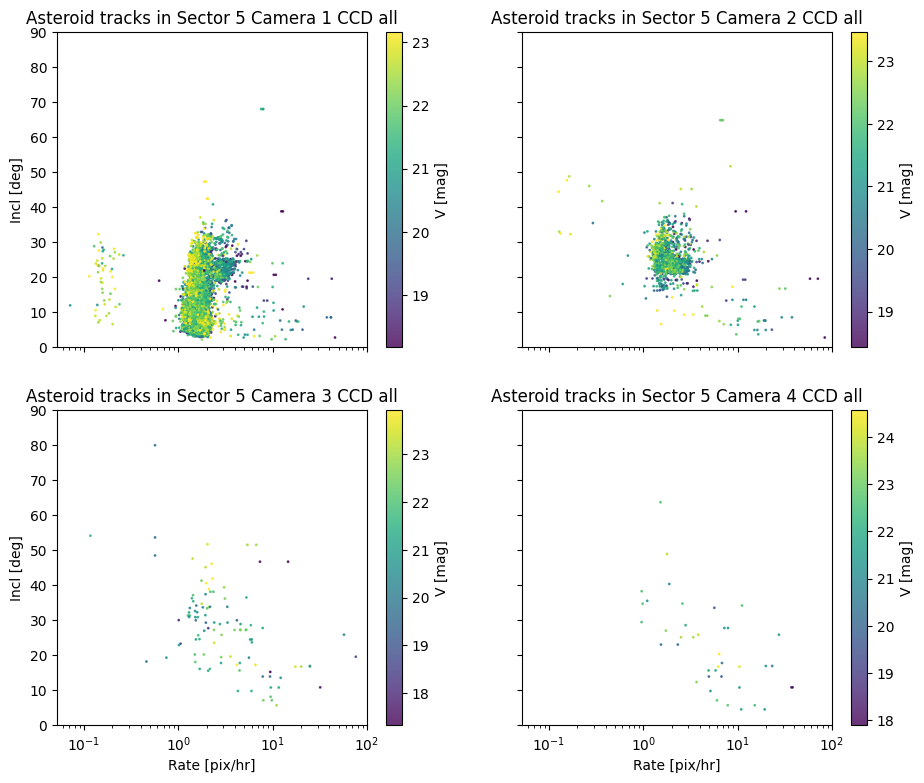

In [87]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(11,9))

for k in range(4):
    vmin, vmax = np.percentile(vmag[k], [3,97])

    bar = ax.ravel()[k].scatter(rate[k], incl[k], c=vmag[k], 
                      vmin=vmin, vmax=vmax, s=1, 
                      marker="o", alpha=.8)
    # ax.ravel()[k].axhline(50, c="tab:red", lw=1)
    ax.ravel()[k].set_title(f"Asteroid tracks in Sector {sector} Camera {k + 1} CCD all")
    plt.colorbar(bar, label="V [mag]", ax=ax.ravel()[k])
    ax.ravel()[k].set_xscale("log")
    
    ax.ravel()[k].set_ylim(0, 90)
    ax.ravel()[k].set_xlim(0, 100)

ax[1, 0].set_xlabel("Rate [pix/hr]")
ax[1, 1].set_xlabel("Rate [pix/hr]")
ax[0, 0].set_ylabel("Incl [deg]")
ax[1, 0].set_ylabel("Incl [deg]")
# plt.savefig(f"{os.path.dirname(PACKAGEDIR)}/data/figures/tess-ffi_s{sector:04}_track_time.pdf")
plt.show()

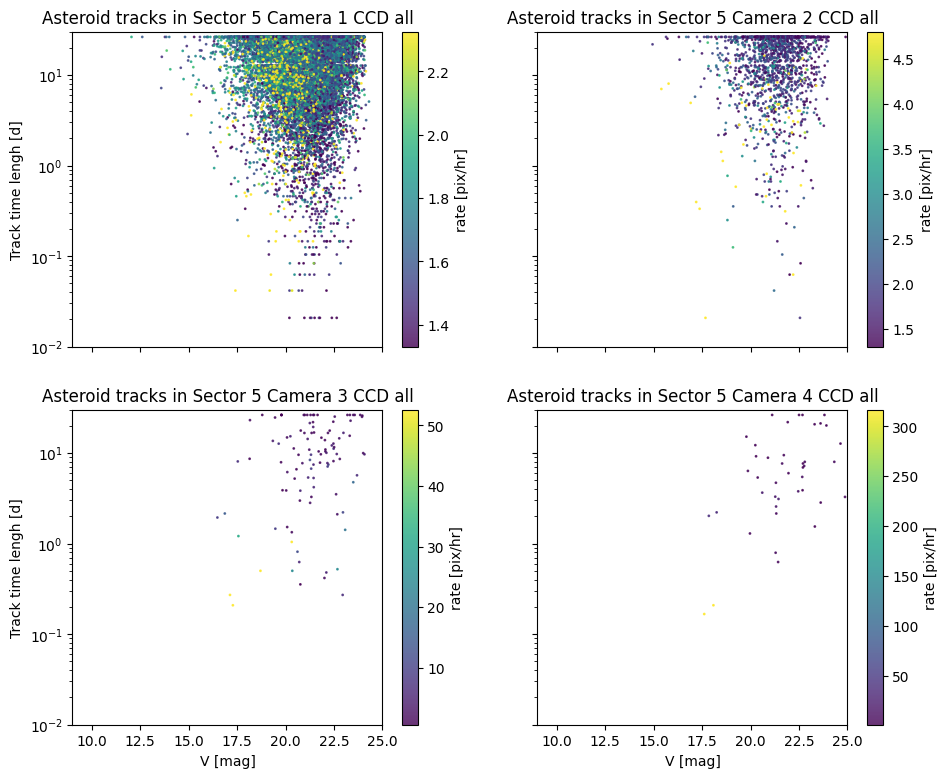

In [83]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(11,9))

for k in range(4):
    vmin, vmax = np.percentile(rate[k], [3,97])

    bar = ax.ravel()[k].scatter(vmag[k], track_time[k], c=rate[k], 
                      vmin=vmin, vmax=vmax, s=1, 
                      marker="o", alpha=.8)
    # ax.ravel()[k].axhline(50, c="tab:red", lw=1)
    ax.ravel()[k].set_title(f"Asteroid tracks in Sector {sector} Camera {k + 1} CCD all")
    plt.colorbar(bar, label="rate [pix/hr]", ax=ax.ravel()[k])
    ax.ravel()[k].set_yscale("log")
    
    ax.ravel()[k].set_ylim(0.01, 30)
    ax.ravel()[k].set_xlim(9, 25)

ax[1, 0].set_xlabel("V [mag]")
ax[1, 1].set_xlabel("V [mag]")
ax[0, 0].set_ylabel("Track time lengh [d]")
ax[1, 0].set_ylabel("Track time lengh [d]")
plt.savefig(f"{os.path.dirname(PACKAGEDIR)}/data/figures/tess-ffi_s{sector:04}_track_time.pdf")
plt.show()

In [80]:
jpl_sb_bright.iloc[1]["id"]

'A892 SC'

In [70]:
sb_ephems_lowres[1]

,time,sector,camera,ccd,column,row,pixels_per_hour,ra,dec,vmag,sun_distance,obs_distance,phase_angle
0,2.458438e+06,5,1,4,858.678667,1338.299765,1.489850,61.204160,7.056030,13.703000,2.936227,1.971147,5.185300
1,2.458438e+06,5,1,4,859.410700,1338.473042,1.494276,61.200135,7.054273,13.702786,2.936247,1.971108,5.181648
2,2.458438e+06,5,1,4,860.144970,1338.644547,1.498578,61.196096,7.052524,13.702572,2.936267,1.971070,5.177991
3,2.458438e+06,5,1,4,860.881440,1338.814303,1.502757,61.192042,7.050782,13.702360,2.936287,1.971033,5.174331
4,2.458438e+06,5,1,4,861.620074,1338.982334,1.506817,61.187975,7.049048,13.702147,2.936307,1.970995,5.170667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,2.458464e+06,5,1,4,1780.738956,1371.707723,0.929813,56.067237,5.883578,13.978773,2.961488,2.053571,8.822251
1192,2.458464e+06,5,1,4,1781.218115,1371.739259,0.928063,56.064654,5.882885,13.979195,2.961508,2.053705,8.828053
1193,2.458464e+06,5,1,4,1781.695517,1371.772427,0.926368,56.062081,5.882185,13.979617,2.961529,2.053839,8.833853
1194,2.458464e+06,5,1,4,1782.171155,1371.807247,0.924727,56.059520,5.881478,13.980039,2.961549,2.053972,8.839650


In [75]:
sb_ephems_lowres[1].time.values[0]

2458437.9953312385

In [69]:
from tess_ephem.ephem import _get_horizons_ephem

In [77]:
Time(sb_ephems_lowres[1].time.values[-1], format="jd")

<Time object: scale='utc' format='jd' value=2458464.2658294924>

In [97]:
jpl_sb_bright

,index,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",ra,dec,V_mag,name,id,H
0,0,3 Juno (A804 RA),03:44:48.02,-04:20:36.2,-40000.0,-30000.0,48000.0,7.37,-28.680,-9.390,56.200083,-4.343389,7.37,3 Juno,A804 RA,5.17
1,1,339 Dorothea (A892 SC),03:53:28.73,+06:14:05.0,-30000.0,10000.0,32000.0,13.7,-30.860,-7.638,58.369708,6.234722,13.70,339 Dorothea,A892 SC,9.46
2,2,397 Vienna (A894 YA),04:37:50.99,+13:44:26.2,9000.0,40000.0,38000.0,11.9,-35.710,-23.010,69.462458,13.740611,11.90,397 Vienna,A894 YA,9.42
3,3,509 Iolanda (A903 HD),04:44:28.69,+09:37:31.9,20000.0,20000.0,27000.0,12.5,-30.900,-15.990,71.119542,9.625528,12.50,509 Iolanda,A903 HD,8.45
4,4,510 Mabella (A903 KA),03:51:23.70,+10:52:57.0,-30000.0,30000.0,42000.0,13.8,-34.440,-11.640,57.848750,10.882500,13.80,510 Mabella,A903 KA,9.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21519,140,(2023 EK),10:15:53.16,-72:08:40.2,90000.0,-20000.0,78000.0,23.5,-58.850,-44.280,153.971500,-72.144500,23.50,NaN,2023 EK,NaN
21520,141,(2023 HQ2),11:37:39.90,-55:17:16.0,100000.0,40000.0,140000.0,23.9,14.310,-23.470,174.416250,-55.287778,23.90,NaN,2023 HQ2,NaN
21521,152,C/2013 P3 (Palomar),01:36:20.57,-60:12:55.5,-100000.0,20000.0,110000.0,20.3N,-6.886,2.634,24.085708,-60.215417,20.30,C/2013 P3,Palomar,NaN
21522,157,C/2020 H6 (ATLAS),10:31:05.37,-61:09:33.6,100000.0,20000.0,100000.0,20.1N,6.106,-13.150,157.772375,-61.159333,20.10,C/2020 H6,ATLAS,NaN


In [98]:
row

index                                             20481
Object name                    C/2011 KP36 (Spacewatch)
Astrometric RA (hh:mm:ss)                   05:02:08.33
Astrometric Dec (dd mm'ss")                 +01:22:36.4
Dist. from center RA (")                        30000.0
Dist. from center Dec (")                       -8000.0
Dist. from center Norm (")                      32000.0
Visual magnitude (V)                              18.3N
RA rate ("/h)                                    -12.96
Dec rate ("/h)                                   -2.876
ra                                            75.534708
dec                                            1.376778
V_mag                                              18.3
name                                        C/2011 KP36
id                                           Spacewatch
H                                                   NaN
Name: 20160, dtype: object

In [102]:
"Tmag" in ast.columns

True

In [103]:
jpl_sb_bright["H"] = np.nan
for k, row in tqdm(jpl_sb_bright.iterrows(), total=len(jpl_sb_bright)):
    if k in sb_ephems_lowres.keys():
        try:
            ast = _get_horizons_ephem(row["id"], 
                                      start=Time(sb_ephems_lowres[k].time.values[0], format="jd"), 
                                      stop=Time(sb_ephems_lowres[k].time.values[-1], format="jd"))
        except ValueError:
            ast = _get_horizons_ephem(row["name"], 
                                      start=Time(sb_ephems_lowres[k].time.values[0], format="jd"), 
                                      stop=Time(sb_ephems_lowres[k].time.values[-1], format="jd"))
        if "H" in ast.columns:
            jpl_sb_bright.loc[k, "H"] = np.nanmedian(ast["H"].value)

  0%|                                                                                       | 0/21524 [00:00<?, ?it/s]/Users/jorgemarpa/.pyenv/versions/tess-asteroids-v2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
100%|███████████████████████████████████████████████████████████████████████████| 21524/21524 [08:46<00:00, 40.85it/s]


In [108]:
a, d, V, pph = [], [], [], []
table = pd.DataFrame([jpl_sb_bright.name, jpl_sb_bright.V_mag, jpl_sb_bright.H, jpl_sb_bright.loc[:, 'RA rate ("/h)']], columns=jpl_sb_bright.index, index=["name", "Vmag", "H", "rate_aph"]).T

for k, val in tqdm(sb_ephems_lowres.items(), total=len(sb_ephems_lowres)):
    if len(val) == 0:
        continue
    table.loc[k, "a"] = np.nanmedian(val.sun_distance.values)
    table.loc[k, "obs_dist"] = np.nanmedian(val.obs_distance.values)
    table.loc[k, "Vmag_mean"] = np.nanmedian(val.vmag.values)
    table.loc[k, "rate_pph"] = np.nanmedian(val.pixels_per_hour.values)

100%|██████████████████████████████████████████████████████████████████████████| 18851/18851 [00:24<00:00, 774.76it/s]


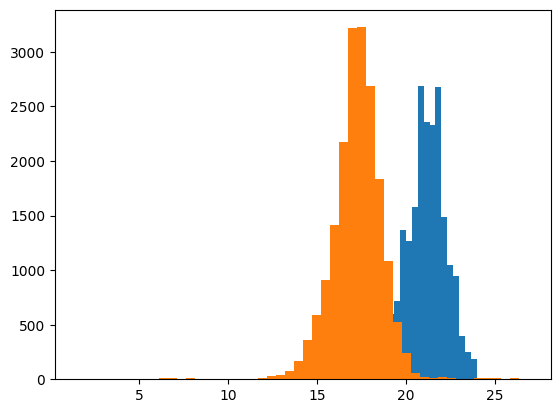

In [122]:
plt.hist(table.Vmag, bins=50)
plt.hist(table.H, bins=50)
plt.show()

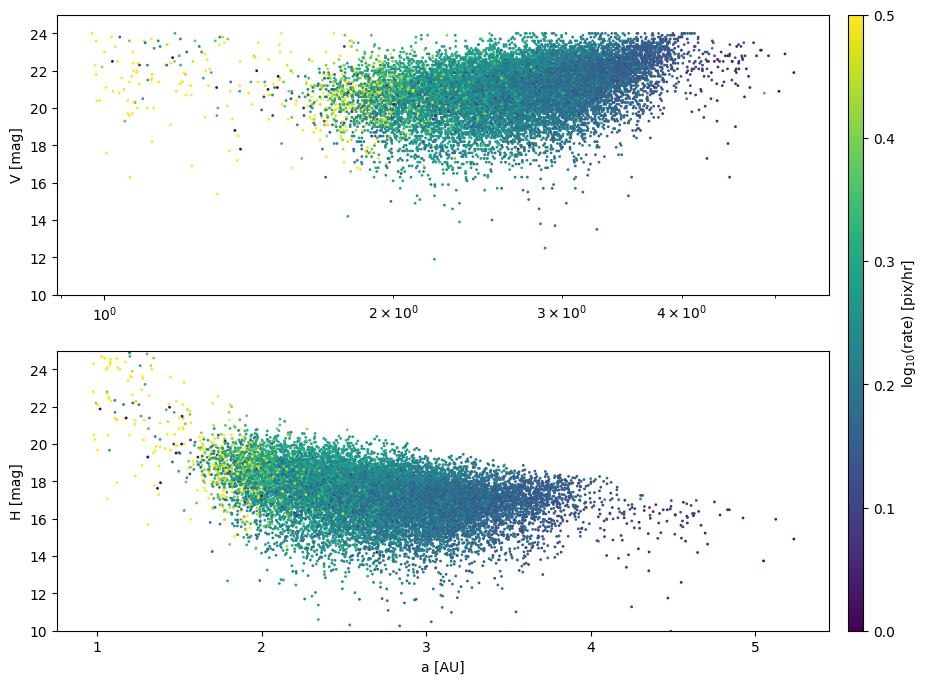

In [123]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

im = ax[0].scatter(table.a[table.a.values<5.5], table.Vmag[table.a.values<5.5], s=1, c=np.log10(table.rate_pph[table.a.values<5.5]), vmin=0, vmax=0.5)
ax[1].scatter(table.a[table.a.values<5.5], table.H[table.a.values<5.5], s=1, c=np.log10(table.rate_pph[table.a.values<5.5]), vmin=0, vmax=0.5)

plt.colorbar(im, ax=ax, location="right", aspect=40, label="log$_{10}$(rate) [pix/hr]", pad=0.02)

ax[0].set_ylabel("V [mag]")
ax[1].set_ylabel("H [mag]")
ax[1].set_xlabel("a [AU]")

ax[0].set_xscale("log")
# ax[1].set_xscale("log")

ax[0].set_ylim(10, 25)
ax[1].set_ylim(10, 25)

# ax[1].set_ylim(0, 10)

plt.show()

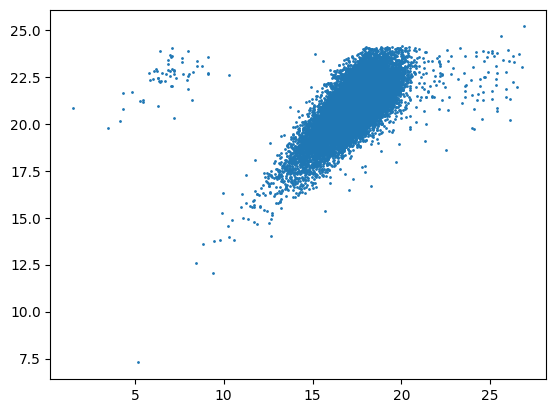

In [115]:
plt.scatter(table.H, table.Vmag_mean, s=1)
plt.show()